In [3]:
##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [4]:
warnings.filterwarnings('ignore')

In [5]:
##
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

In [6]:
VER = 1

In [7]:
##
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
print(train.shape)

(750000, 12)


In [ ]:
train.columns

In [8]:
train['isnull_Episode_Length_minutes'] = train['Episode_Length_minutes'].isnull().astype(int)
train["NaNs"] = np.float32(0)
for i,c in enumerate(train.columns):
    train["NaNs"] += train[c].isna()*2**i


In [9]:
test['isnull_Episode_Length_minutes'] = test['Episode_Length_minutes'].isnull().astype(int)
test["NaNs"] = np.float32(0)
for i,c in enumerate(test.columns):
    test["NaNs"] += test[c].isna()*2**i

In [10]:
DROP_COLS = ['id']
TARGET_COL = ['Listening_Time_minutes']
CAT_COLS = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment', 'isnull_Episode_Length_minutes', 'NaNs']
NUM_COLS = [col for col in train.columns if col not in DROP_COLS + CAT_COLS + TARGET_COL]

FEATURES = CAT_COLS + NUM_COLS

In [11]:
# STATISTICS TO AGGREGATE FOR OUR FEATURE GROUPS
STATS = ["mean","std","count","nunique","median","min","max","skew"]
STATS2 = ["mean","std"]

In [12]:
def make_histogram():
    pass

In [13]:
%%time

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train)))
pred = np.zeros((len(test)))

# OUTER K FOLD
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"### OUTER Fold {i+1} ###")

    X_train = train.loc[train_index,FEATURES+TARGET_COL].reset_index(drop=True).copy()
    y_train = train.loc[train_index,'Listening_Time_minutes']

    X_valid = train.loc[test_index,FEATURES].reset_index(drop=True).copy()
    y_valid = train.loc[test_index,'Listening_Time_minutes']

    X_test = test[FEATURES].reset_index(drop=True).copy()

    # INNER K FOLD (TO PREVENT LEAKAGE WHEN USING Listening_Time_minutes)
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2 = X_train.loc[train_index2,FEATURES+TARGET_COL].copy()
        X_valid2 = X_train.loc[test_index2,FEATURES].copy()

        ### FEATURE SET 1 (uses Listening_Time_minutes) ###
        col = "Episode_Length_minutes"
        tmp = X_train2.groupby(col).Listening_Time_minutes.agg(STATS)
        tmp.columns = [f"TE1_elm_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2,c] = X_valid2[c].values
        
        ### FEATURE SET 1 (uses Listening_Time_minutes) ###
        col = "Episode_Length_minutes"
        tmp = X_train2.groupby(col).Listening_Time_minutes.agg(STATS)
        tmp.columns = [f"TE1_elm_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2,c] = X_valid2[c].values
            

        ### FEATURE SET 2 (uses Listening_Time_minutes) ###
        for col in CAT_COLS:
            tmp = X_train2.groupby(col).Listening_Time_minutes.agg(STATS2)
            tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
            X_valid2 = X_valid2.merge(tmp, on=col, how="left")
            for c in tmp.columns:
                X_train.loc[test_index2,c] = X_valid2[c].values

    ### FEATURE SET 1 (uses Listening_Time_minutes) ###
    col = "Episode_Length_minutes"
    tmp = X_train.groupby(col).Listening_Time_minutes.agg(STATS)
    tmp.columns = [f"TE1_elm_{s}" for s in STATS]
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 2 (uses Listening_Time_minutes) ###
    for col in CAT_COLS:
        tmp = X_train.groupby(col).Listening_Time_minutes.agg(STATS2)
        tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 3 (does not use Listening_Time_minutes) ###
    for col in CAT_COLS:
        col2 = "Episode_Length_minutes"
        tmp = X_train.groupby(col)[col2].agg(STATS2)
        tmp.columns = [f"FE3_{col}_elm_{s}" for s in STATS2]
        X_train = X_train.merge(tmp, on=col, how="left")
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    # CONVERT TO CAT_COLS SO XGBOOST RECOGNIZES THEM
    X_train[CAT_COLS] = X_train[CAT_COLS].astype("category")
    X_valid[CAT_COLS] = X_valid[CAT_COLS].astype("category")
    X_test[CAT_COLS] = X_test[CAT_COLS].astype("category")

    # DROP Listening_Time_minutes THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(TARGET_COL,axis=1)

    # BUILD MODEL
    model = XGBRegressor(
        enable_categorical=True,
        random_state=42
    )
    
    # TRAIN MODEL
    COLS = X_train.columns
    model.fit(
        X_train[COLS], y_train,
        eval_set=[(X_valid[COLS], y_valid)],  
        verbose=300,
    )

    # PREDICT OOF AND TEST
    oof[test_index] = model.predict(X_valid[COLS])
    pred += model.predict(X_test[COLS])

pred /= FOLDS

### OUTER Fold 1 ###
 ## INNER Fold 1 (outer fold 1) ##
 ## INNER Fold 2 (outer fold 1) ##
 ## INNER Fold 3 (outer fold 1) ##
 ## INNER Fold 4 (outer fold 1) ##
 ## INNER Fold 5 (outer fold 1) ##
[0]	validation_0-rmse:21.20555
[99]	validation_0-rmse:12.96037
### OUTER Fold 2 ###
 ## INNER Fold 1 (outer fold 2) ##
 ## INNER Fold 2 (outer fold 2) ##
 ## INNER Fold 3 (outer fold 2) ##
 ## INNER Fold 4 (outer fold 2) ##
 ## INNER Fold 5 (outer fold 2) ##
[0]	validation_0-rmse:21.24406
[99]	validation_0-rmse:13.01096
### OUTER Fold 3 ###
 ## INNER Fold 1 (outer fold 3) ##
 ## INNER Fold 2 (outer fold 3) ##
 ## INNER Fold 3 (outer fold 3) ##
 ## INNER Fold 4 (outer fold 3) ##
 ## INNER Fold 5 (outer fold 3) ##
[0]	validation_0-rmse:21.22305
[99]	validation_0-rmse:13.03420
### OUTER Fold 4 ###
 ## INNER Fold 1 (outer fold 4) ##
 ## INNER Fold 2 (outer fold 4) ##
 ## INNER Fold 3 (outer fold 4) ##
 ## INNER Fold 4 (outer fold 4) ##
 ## INNER Fold 5 (outer fold 4) ##
[0]	validation_0-rmse:21.26

# Overall CV Score
Below we display overall cv score and save oof predictions to disk, so we can use them later to assist finding ensemble weights with our other models.

In [14]:
# COMPUTE OVERALL CV SCORE
true = train.Listening_Time_minutes.values
s = np.sqrt(mean_squared_error(true, oof))
print(f"=> Overall CV Score = {s}")

=> Overall CV Score = 13.00127228353097


# XGB Feature Importance
Here is XGBoost feature importance sorted by `gain`.

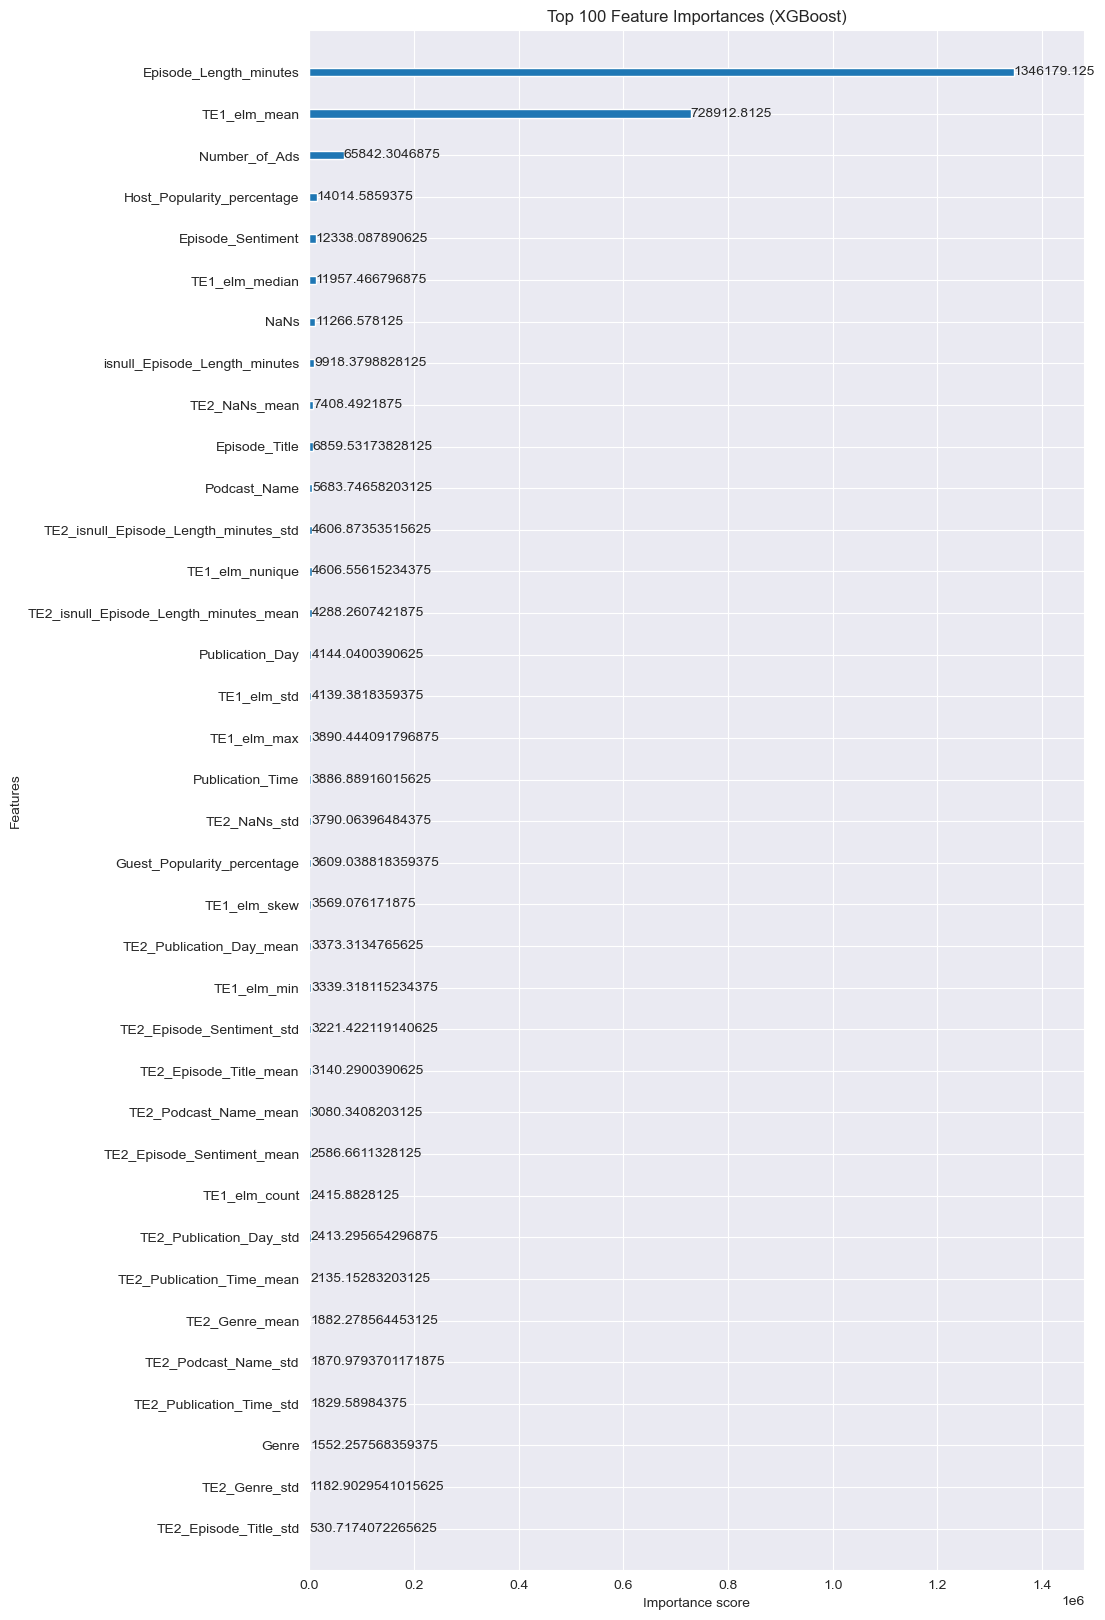

In [15]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, max_num_features=100, importance_type='gain',ax=ax)
plt.title("Top 100 Feature Importances (XGBoost)")
plt.show()

# Make Submission CSV
We save our test predictions to submission.csv and plot our predictions. 

In [16]:
sub = pd.read_csv("data/sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission_v{VER}.csv",index=False)
sub.head()

,id,Listening_Time_minutes
0,750000,45.44
1,750001,45.44
2,750002,45.44
3,750003,45.44
4,750004,45.44


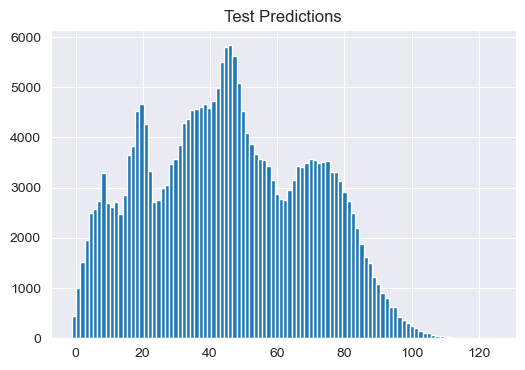

In [17]:
plt.figure(figsize=(6,4))
plt.hist(sub.Price,bins=100)
plt.title("Test Predictions")
plt.show()